In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy

import k3d
import yaml
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
import json

import torch

import trimesh.transformations as tt
import trimesh
from io import BytesIO

In [3]:
import os
os.environ['OMP_NUM_THREADS'] = '8'

In [4]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768):
    
    plot = k3d.plot(height=plot_height)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances:
            max_dist = np.max(samples_distances)

            colors = k3d.helpers.map_colors(
                samples_distances, k3d.colormaps.basic_color_maps.WarmCool, [0, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            k3d_points = k3d.points(samples, point_size=samples_psize, color=samples_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            k3d_vectors = k3d.vectors(samples, directions, 
                                      color=samples_color, 
                                      head_size=10.0, 
                                      line_width=0.1)
            plot += k3d_vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))

In [5]:
# mm/pixel
HIGH_RES = 0.02
MED_RES = 0.05
LOW_RES = 0.125
XLOW_RES = 0.25

## 1. Working with point patches

In [23]:
from sharpf.data import DataGenerationException
from sharpf.utils.abc_utils.abc.abc_data import ABCModality, ABCChunk, ABC_7Z_FILEMASK
from sharpf.data.annotation import ANNOTATOR_BY_TYPE
from sharpf.data.camera_pose_manager import POSE_MANAGER_BY_TYPE
from sharpf.data.datasets.sharpf_io import save_depth_maps
from sharpf.data.imaging import IMAGING_BY_TYPE
from sharpf.data.noisers import NOISE_BY_TYPE
from sharpf.utils.abc_utils.abc import feature_utils
from sharpf.utils.py_utils.console import eprint_t
from sharpf.utils.py_utils.os import add_suffix
from sharpf.utils.py_utils.config import load_func_from_config
from sharpf.utils.abc_utils.mesh.io import trimesh_load
from sharpf.utils.plotting import display_depth_sharpness
from sharpf.utils.camera_utils.camera_pose import camera_to_display

In [9]:
with ABCChunk(['/data/abc_0056_obj_v00.7z', '/data/abc_0056_feat_v00.7z']) as data_holder:
    item = data_holder[0]

In [10]:
item.item_id

'00560001_b9953e64f327f7706c42a1f3_000'

In [11]:
mesh = trimesh_load(item.obj)
features = yaml.load(item.feat, Loader=yaml.Loader)

In [12]:
import json
with open('/code/scripts/data_scripts/configs/depthmap_datasets/dataset_config_high_res_clean_64x64.json') as config_file:
    config = json.load(config_file)

config

{'shape_fabrication_extent': 10.0,
 'short_curve_quantile': 0.25,
 'base_n_points_per_short_curve': 8,
 'base_resolution_3d': 0.125,
 'camera_pose': {'type': 'composite',
  'sequences': [{'type': 'sphere_to_origin', 'n_images': 10},
   {'type': 'xy_translation', 'n_images': 100},
   {'type': 'z_rotation', 'n_images': 5}]},
 'imaging': {'type': 'raycasting',
  'projection': 'ortho',
  'resolution_image': 64,
  'resolution_3d': 0.02,
  'fov': [115, 85, 80],
  'validate_image': True},
 'noise': {'type': 'many_noisers', 'subtype': 'z_direction', 'scale': [0.0]},
 'annotation': {'type': 'surface_based_aabb',
  'distance_upper_bound': 1.0,
  'validate_annotation': True}}

In [13]:
shape_fabrication_extent = config.get('shape_fabrication_extent', 10.0)
base_n_points_per_short_curve = config.get('base_n_points_per_short_curve', 8)
base_resolution_3d = config.get('base_resolution_3d', LOW_RES)

short_curve_quantile = config.get('short_curve_quantile', 0.05)

pose_manager = load_func_from_config(POSE_MANAGER_BY_TYPE, config['camera_pose'])
imaging = load_func_from_config(IMAGING_BY_TYPE, config['imaging'])
noiser = load_func_from_config(NOISE_BY_TYPE, config['noise'])
annotator = load_func_from_config(ANNOTATOR_BY_TYPE, config['annotation'])

In [14]:
def scale_mesh(mesh, features, shape_fabrication_extent, resolution_3d,
               short_curve_quantile=0.05, n_points_per_short_curve=4):
    # compute standard size spatial extent
    mesh_extent = np.max(mesh.bounding_box.extents)
    mesh = mesh.apply_scale(shape_fabrication_extent / mesh_extent)

    # compute lengths of curves
    sharp_curves_lengths = feature_utils.get_curves_extents(mesh, features)

    least_len = np.quantile(sharp_curves_lengths, short_curve_quantile)
    least_len_mm = resolution_3d * n_points_per_short_curve

    scale = least_len_mm / least_len
    mesh = mesh.apply_scale(scale)

    return mesh, scale


In [15]:
mesh, mesh_scale = scale_mesh(mesh, features, shape_fabrication_extent, base_resolution_3d,
                              short_curve_quantile=short_curve_quantile,
                              n_points_per_short_curve=base_n_points_per_short_curve)

mesh = mesh.apply_translation(-mesh.vertices.mean(axis=0))

In [16]:
print(np.max(mesh.bounding_box.extents))

53.91470905763444


In [17]:

display_sharpness(
    mesh, plot_meshvert=False, meshvert_psize=imaging.resolution_3d / 2,
    sharp_vert=None, sharpvert_psize=2. * imaging.resolution_3d,
    samples=None, samples_psize=1. * imaging.resolution_3d,
)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

In [18]:
# generate camera poses
pose_manager.prepare(mesh)

In [19]:
pose_manager_iter = iter(pose_manager)

In [96]:
camera_pose = next(pose_manager_iter)

In [97]:
camera_to_world = np.linalg.inv(camera_pose.world_to_camera_4x4)

# camera_to_world = pose.camera_to_world_4x4

camera_center = np.array([
    camera_pose.frame_origin,
    camera_pose.frame_origin,
    camera_pose.frame_origin,
])

camera_frame = np.array([
    camera_pose.frame_axes
]) * 25

display_sharpness(
    mesh, plot_meshvert=True, meshvert_psize=imaging.resolution_3d / 2,
    sharp_vert=camera_pose.camera_to_world(imaging.rays_origins), sharpvert_psize=0.5,
    samples=camera_center, samples_psize=5.0,
    directions=camera_frame
)

Output()

In [98]:
# extract neighbourhood
try:
    image, points, normals, mesh_face_indexes = \
        imaging.get_image_from_pose(mesh, camera_pose, return_hit_face_indexes=True)
except DataGenerationException as e:
    eprint_t(str(e))

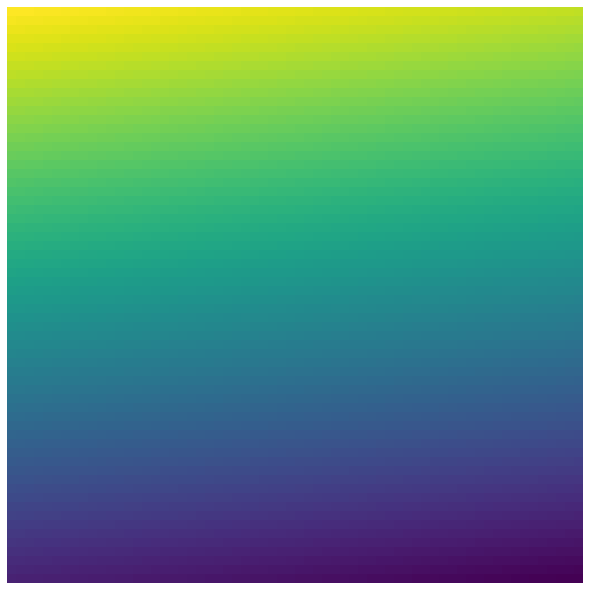

In [99]:
display_depth_sharpness(
    depth_images=[camera_to_display(image)]
)

In [100]:
display_sharpness(
    mesh, plot_meshvert=True, meshvert_psize=imaging.resolution_3d / 2,
    sharp_vert=camera_pose.camera_to_world(imaging.rays_origins), sharpvert_psize=0.5,
    samples=camera_pose.camera_to_world(imaging.image_to_points(image)), samples_psize=0.1,
    directions=None
)

Output()

In [101]:
nbhood, mesh_vertex_indexes, mesh_face_indexes = \
            feature_utils.submesh_from_hit_surfaces(mesh, features, mesh_face_indexes)

# create annotations: condition the features onto the nbhood
nbhood_features = feature_utils.compute_features_nbhood(mesh, features, mesh_vertex_indexes, mesh_face_indexes)

# remove vertices lying on the boundary (sharp edges found in 1 face only)
nbhood_features = feature_utils.remove_boundary_features(nbhood, nbhood_features, how='edges')

In [102]:
i = noiser.make_noise(
    camera_pose.world_to_camera(points),
    normals,
    z_direction=np.array([0., 0., -1.]))

In [103]:
configuration, noisy_points = next(i)

In [104]:
annotator.validate_annotation = False

In [105]:
# compute the TSharpDF
try:
    distances, directions, has_sharp = annotator.annotate(
        nbhood, nbhood_features, camera_pose.camera_to_world(noisy_points))
except DataGenerationException as e:
    eprint_t(str(e))

In [106]:
display_sharpness(
    nbhood, plot_meshvert=True, meshvert_psize=imaging.resolution_3d / 2,
#     sharp_vert=camera_pose.camera_to_world(imaging.rays_origins), sharpvert_psize=0.5,
    samples=camera_pose.camera_to_world(imaging.image_to_points(image)), samples_psize=0.1,
    samples_distances=distances
)

Output()

In [107]:
# convert everything to images
ray_indexes = np.where(image.ravel() != 0)[0]
noisy_image = imaging.points_to_image(noisy_points, ray_indexes)
normals = imaging.points_to_image(normals, ray_indexes, assign_channels=[0, 1, 2])
distances = imaging.points_to_image(distances.reshape(-1, 1), ray_indexes, assign_channels=[0])
directions = imaging.points_to_image(directions, ray_indexes, assign_channels=[0, 1, 2])

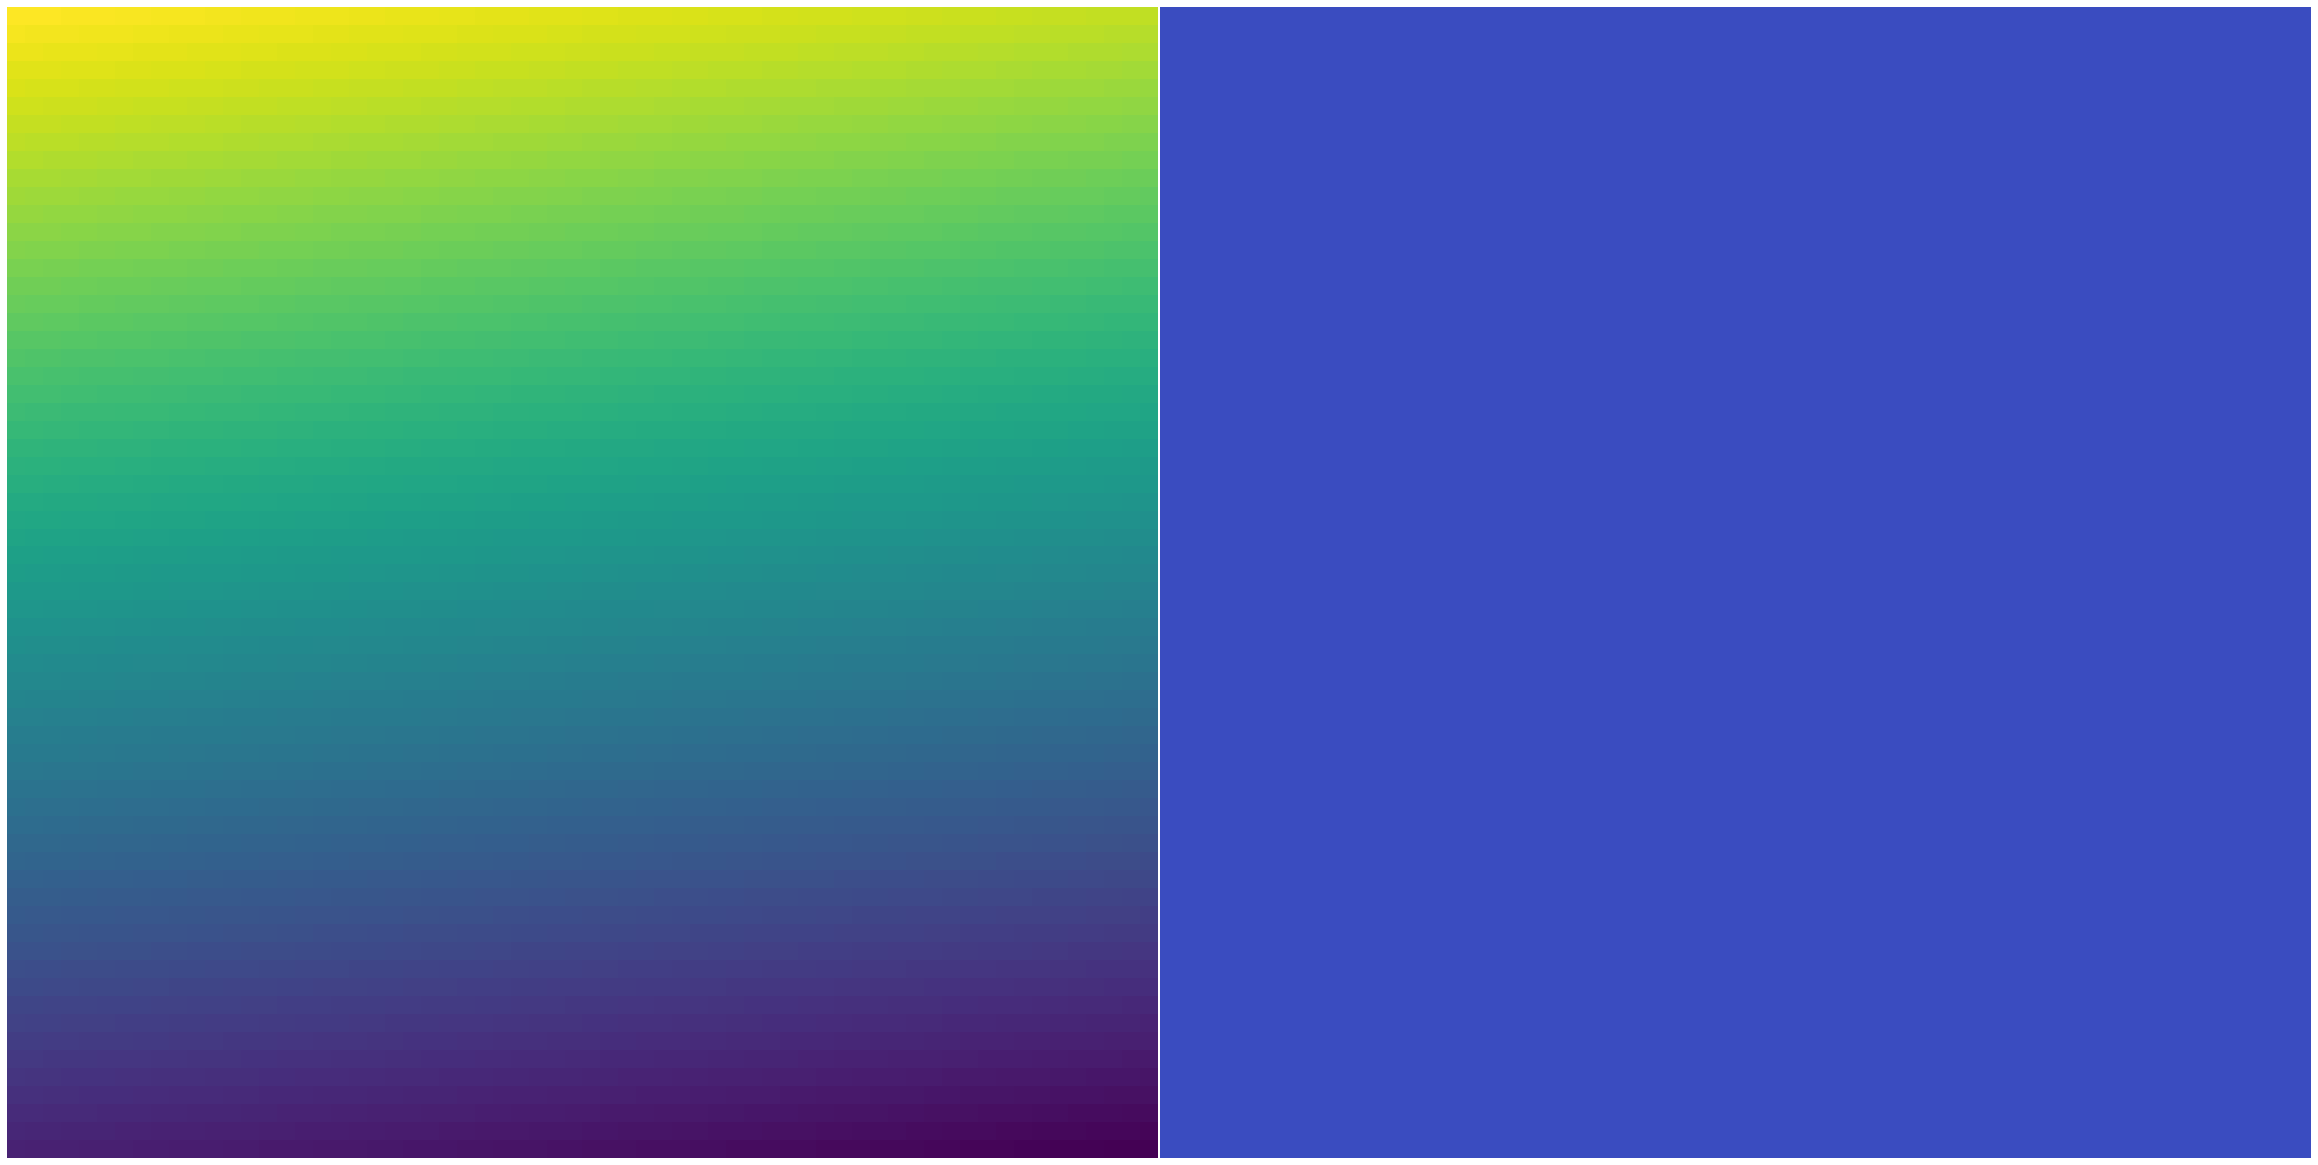

In [108]:
display_depth_sharpness(
    depth_images=[camera_to_display(image)],
    sharpness_images=[camera_to_display(distances)],
    axes_size=(16, 16), 
)

In [ ]:
# compute statistics
num_sharp_curves = len([curve for curve in nbhood_features['curves'] if curve['sharp']])
num_surfaces = len(nbhood_features['surfaces'])

patch_info = {
    'image': noisy_image,
    'normals': normals,
    'distances': distances,
    'directions': directions,
    'item_id': item.item_id,
    'orig_vert_indices': mesh_vertex_indexes,
    'orig_face_indexes': mesh_face_indexes,
    'has_sharp': has_sharp,
    'num_sharp_curves': num_sharp_curves,
    'num_surfaces': num_surfaces,
    'camera_pose': camera_pose.camera_to_world_4x4,
    'mesh_scale': mesh_scale
}

In [ ]:
point_patches = [patch_info]

In [ ]:
save_depth_maps(point_patches, '/logs/abc_0056_test.hdf5')

In [ ]:
!ls -lah /logs/abc_0056_test.hdf5